# Mortality Data Analysis

### Preprocessing

In [12]:
def education_calc(row):
    flag = row['education_reporting_flag']
    rev_89 = row['education_1989_revision']
    rev_03 = row['education_2003_revision']
    
    # 1989 recode
    if flag == 0:
        # If not stated
        if rev_89 == 99:
            return 0
        # If primary school or less
        elif rev_89 >= 0 and rev_89 <= 8:
            return 1
        # If some amount of secondary school
        elif rev_89 >= 9 and rev_89 <= 12:
            return 2
        # Complete or currently working on associate's or bachelor's degree
        elif rev_89 >= 13 and rev_89 <= 16:
            return 3
        # >4 years of school
        else:
            return 4
    # 2003 recode
    elif flag == 1:
        # "unknown"
        if rev_03 == 9:
            return 0
        # primary school
        elif rev_03 == 1:
            return 1
        # Some amount of secondary school
        elif rev_03 == 2 or rev_03 == 3:
            return 2
        # College up to bachelors
        elif rev_03 == 4 or rev_03 == 5 or rev_03 == 6:
            return 3
        # >4 years
        else:
            return 4
    # Nothing reported
    else:
        return 0

In [13]:
## Here we concatinate all csv's into one single one.
#File loading method stack overflow link: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#All dataframe methods learned from pandas documentation
#np.where learned from numpy documentation

import numpy as np
import pandas as pd
import glob
import os
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn import preprocessing
import matplotlib.pyplot as plt


filename = 'MortalityCondensed.csv'
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None 

def process_files(local_path):
    #Load all .csv files in the mortality directory
    all_files = glob.glob(local_path + "/*.csv")
    dataframe = pd.DataFrame()
    file_list = []

    for file in all_files:
        df = pd.read_csv(file, index_col = None, header = 0, low_memory = False)

        dfInterest = df[['sex','race','detail_age','month_of_death', 'manner_of_death', 'education_reporting_flag','education_2003_revision','education_1989_revision','hispanic_origin']] #Isolate columns we need
        dfInterest['binary_male'] = np.where(dfInterest['sex']=='M', 1, 0)
        dfInterest['manner_of_death_cleaned'] = np.where(np.isnan(dfInterest['manner_of_death']), 0, dfInterest['manner_of_death'])
        #dfInterest['binary_suicide'] = np.where(dfInterest['manner_of_death']==2, 1, 0) #create the binary suicide column

        #Recode education to get rid of NaNs. Code 18 represents where we have no data.
        dfInterest['education'] = dfInterest.apply(education_calc, axis=1)
        print(dfInterest['education'].head())

        #Recode race to give us more meaningful categories 0 hispanic, 1 white, 2 black, 3 asian
        dfInterest['binary_white'] = np.where(dfInterest['race'] == 1, 1, 0)
        dfInterest['binary_black'] = np.where(dfInterest['race'] == 2, 1, 0)
        dfInterest['binary_asian'] = np.where(dfInterest['race'] > 2, 1, 0)
        dfInterest['binary_hispanic'] = np.where(dfInterest['hispanic_origin'] > 199, 1, 0)        
        file_list.append(dfInterest) #add the new dataframe to the list
    
    dataframe = pd.concat(file_list) #concat the whole list to the final dataframe
    finaldf = dataframe.drop(columns=['race', 'sex', 'education_reporting_flag','education_2003_revision','education_1989_revision'])

    # Reordering
    finaldf = finaldf[['binary_male', 'binary_white', 'binary_black', 'binary_asian', 'binary_hispanic',
                      'detail_age', 'month_of_death', 'education','manner_of_death_cleaned']]
    finaldf.to_csv(filename)
    finaldf.head()
    print(finaldf.isnull().sum())#showing number of null values, shoulw be 0 after recode


## Building Test and Train sets

In [14]:
# Check if base_file exists
# If not, create it
if not os.path.isfile(filename):
    process_files("mortality")
df = pd.read_csv(filename, header=0, encoding='ISO-8859-1', engine='python')
#new_df = df.sample(int(len(df)/4))
#print(new_df.head())
# Split into training and test
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
df = df[df.manner_of_death_cleaned != 0]
print(df['manner_of_death_cleaned'].value_counts())

msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

# 1:Accident
# 2:Suicide
# 3:Homicide
# 4:Pending investigation
# 5:Could not determine
# 6:Self-Inflicted
# 7:Natural

7.0    19914162
1.0     1350268
2.0      423361
3.0      200528
5.0      119756
4.0       55808
Name: manner_of_death_cleaned, dtype: int64


# Predicting Suicide vs Non-Suicide

### Setting up training and test sets

In [16]:
# Y is 1 only if suicide
Y_train = np.where(train.iloc[:,len(train.columns)-1] == 2, 1, 0)
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = np.where(test.iloc[:,len(test.columns)-1] == 2, 1, 0)
X_test = test.iloc[:,1:(len(test.columns)-1)]

### Logistic Regression

In [74]:
%%time
#sources http://scikit-learn.org/stable/modules/sgd.html
#running gridsearchCV on a generic SGCclassifier to seek out optmized meta-paramaters
#########GRIDSEARCH##########################
from sklearn.model_selection import GridSearchCV

def binary_log_reg(X_train, Y_train, X_test, Y_test):
    alpha_arr = [10 ** x for x in range(-6, 1)]
    param_grid = {
        'alpha': alpha_arr
    }
    SGC_generic = SGDClassifier(loss='log', random_state=0)
    SGC_generic_gridsearch = grid_search.GridSearchCV(estimator=SGC_generic, param_grid=param_grid,
                                        n_jobs=4, scoring='accuracy', cv=3)

    SGC_generic_gridsearch.fit(X=X_train, y=Y_train)
    print ("The best estimators are: ")
    print (SGC_generic_gridsearch.best_estimator_)

    print ("Test with best estimator: ")
    print(accuracy_score(Y_test, SGC_generic_gridsearch.best_estimator_.predict(X_test)))

    plt.figure(1)
    plt.plot(alpha_arr, SGC_generic_gridsearch.cv_results_['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Acc")
    plt.plot(alpha_arr, SGC_generic_gridsearch.cv_results_['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Acc")

    ax = plt.gca()
    ax.set_xscale('log')

    plt.xlabel("Alpha")
    plt.ylabel("Acc")
    plt.title("Alpha vs Mean Accuracy Logistic Regression")
    plt.legend(loc='upper right')
    plt.show()
    
binary_log_reg(X_train, Y_train, X_test, Y_test)

KeyboardInterrupt: 

### Decision Tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Test accuracy with best estimator
0.9808705025300303
Working on first plot


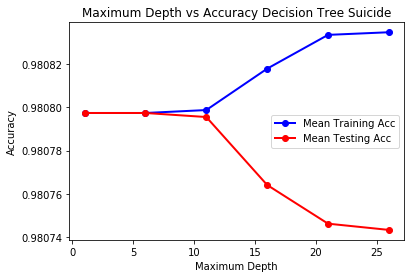

Working on second plot


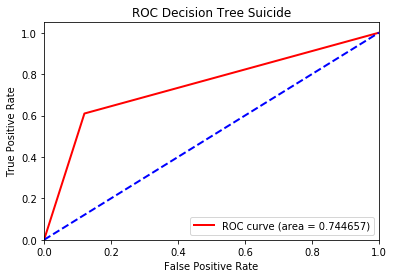

CPU times: user 1min 19s, sys: 22.5 s, total: 1min 42s
Wall time: 14min 48s


In [15]:
%%time
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

def decision_tree(X_train, Y_train, X_test, Y_test, title):
    # from sklearn import grid_search
    depth_arr = np.arange(1,27, 5)
    ###############GridsearchCV#############
    param_grid = {'max_depth': depth_arr
                  #'min_samples_leaf':[1**x for x in range(1,10)]
                 }
    generic_tree = DecisionTreeClassifier()
    gridsearch_generic_tree = GridSearchCV(estimator=generic_tree, param_grid=param_grid, 
                                                       n_jobs=-1, scoring='accuracy', return_train_score=True, cv=3);
    gridsearch_generic_tree.fit(X=X_train, y=Y_train)

    #print("The best estimators are: ")
    print(gridsearch_generic_tree.best_estimator_)

    print("Test accuracy with best estimator")
    print(accuracy_score(Y_test, gridsearch_generic_tree.predict(X_test)))
    #######################################

    print("Working on first plot")
    plt.figure(1)
    plt.plot(depth_arr, gridsearch_generic_tree.cv_results_['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Acc")
    plt.plot(depth_arr, gridsearch_generic_tree.cv_results_['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Acc")

    plt.xlabel("Maximum Depth")
    plt.ylabel("Accuracy")
    plt.title("Maximum Depth vs Accuracy Decision Tree " + title)
    plt.legend(loc='center right')
    plt.show()
    
    print("Working on second plot")
    # ROC stuff
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    fpr, tpr, _ = roc_curve(Y_test, gridsearch_generic_tree.predict_proba(X_test)[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(2)
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=2, color='blue', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Decision Tree ' + title)
    plt.legend(loc="lower right")
    plt.show()
    
decision_tree(X_train, Y_train, X_test, Y_test, "Suicide")

### Feature Importances

Feature Importances for last run
1. feature detail_age (0.729604)
2. feature education (0.095727)
3. feature binary_black (0.086392)
4. feature binary_male (0.063544)
5. feature binary_hispanic (0.019593)
6. feature month_of_death (0.002581)
7. feature binary_asian (0.001825)
8. feature binary_white (0.000733)


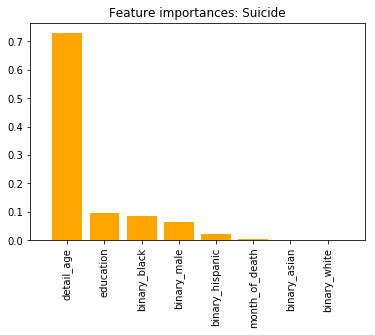

In [28]:
def feature_importances(X_train, Y_train, X_test, Y_test, title):

    # Max depth taken from best gridsearch params
    clf = DecisionTreeClassifier(random_state=0, max_depth=10)
    clf.fit(X_train, Y_train)
    
    features = [types for types in df.dtypes.index if "Unnamed" not in types]
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    ordered_features = list()
    print("Feature Importances for last run")
    for f in range(X_train.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
        ordered_features.append(features[indices[f]])

    #Attemptin to graph importances.
    plt.figure()
    plt.title("Feature importances: " + title)
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="orange", align="center")
    plt.xticks(range(X_train.shape[1]), ordered_features, rotation='vertical')
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
feature_importances(X_train, Y_train, X_test, Y_test, "Suicide")

# Predicting Murder vs Non-Murder

### Setting up training and test sets

In [ ]:
# Y is 1 only if murder
Y_train = np.where(train.iloc[:,len(train.columns)-1] == 3, 1, 0)
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = np.where(test.iloc[:,len(test.columns)-1] == 3, 1, 0)
X_test = test.iloc[:,1:(len(test.columns)-1)]

### Decision Tree

In [ ]:
#Checking Feature importances
#THIS CELL DOES NOT WORK. Re-org needed.

features = [types for types in df.dtypes.index if "Unnamed" not in types]
importances = rforest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[f], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

#Attemptin to graph importances.
plt.figure()
plt.title("Feature importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Feature Importances

Feature Importances for last run
1. feature detail_age (0.729604)
2. feature education (0.095727)
3. feature binary_black (0.086392)
4. feature binary_male (0.063544)
5. feature binary_hispanic (0.019593)
6. feature month_of_death (0.002581)
7. feature binary_asian (0.001825)
8. feature binary_white (0.000733)


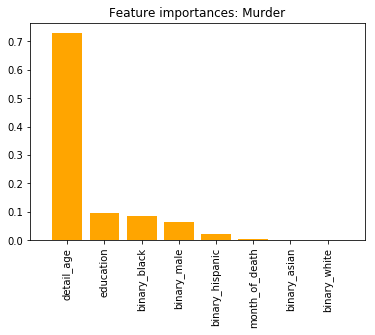

In [29]:
feature_importances(X_train, Y_train, X_test, Y_test, "Murder")

# Multiclass Classification

### Setting up training and test sets

In [33]:
# No longer binarizing Y vectors (Multi-class)
Y_train = train.iloc[:,len(train.columns)-1]
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = test.iloc[:,len(test.columns)-1]
X_test = test.iloc[:,1:(len(test.columns)-1)]


In [ ]:
X_test

### One vs Rest Multiclass using Decision Trees

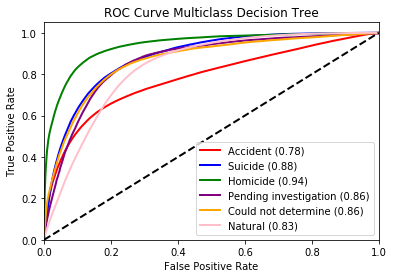

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Example from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# Must use 1 vs rest as ROC doesn't do "actual" multiclass
classifier = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10), n_jobs=6)
# Must also binarize y_test for onevsrest
binary_y_test = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 7])

classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)
n_classes = 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# For all classes, calculate and store true, false positive rate, area under curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
labels = ['Accident', 'Suicide', 'Homicide', 'Pending investigation', 'Could not determine', 'Natural']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} ({1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [ ]:
feature_importances(X_train, Y_train, X_test, Y_test, "Decision Tree -- Multi-class")

### Random Forest Classifier

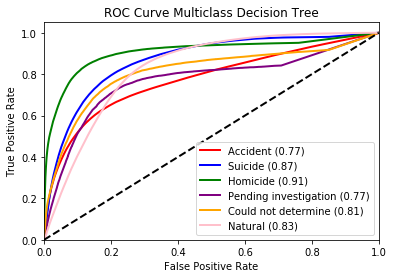

In [38]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Example from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# Must use 1 vs rest as ROC doesn't do "actual" multiclass
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1), n_jobs=-1)
# Must also binarize y_test for onevsrest
binary_y_test = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 7])

classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)
n_classes = 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# For all classes, calculate and store true, false positive rate, area under curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
labels = ['Accident', 'Suicide', 'Homicide', 'Pending investigation', 'Could not determine', 'Natural']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} ({1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [35]:
%%time
############GridsearchCV##########################
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Using 10 trees. (Will attempt more in the future after tuning. Gridsearch?)
rforest = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

# param_grid = { 
#     'n_estimators': [1,10,200,700],
#     'max_features': ['auto', 'sqrt', 'log2']
# }
# CV_rfc = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, Y_train)
# print (rforest.best_params_)

rforest.fit(X_train, Y_train)

Wall time: 2min 38s


In [36]:
#Get accruacy for random forest.
ypred = rforest.predict(X_test)
print(metrics.classification_report(Y_test, ypred))

             precision    recall  f1-score   support

        1.0       0.47      0.20      0.28    270087
        2.0       0.21      0.00      0.01     84321
        3.0       0.49      0.23      0.31     40330
        4.0       0.07      0.00      0.00     11144
        5.0       0.31      0.01      0.02     23994
        7.0       0.92      0.99      0.96   3979704

avg / total       0.87      0.91      0.88   4409580



In [37]:
#Checking Feature importances

features = [types for types in df.dtypes.index if "Unnamed" not in types]
importances = rforest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[f], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

#Attemptin to graph importances.
plt.figure()
plt.title("Feature importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

1. feature binary_male (0.879536)
2. feature binary_white (0.041132)
3. feature binary_black (0.036461)
4. feature binary_asian (0.014784)
5. feature binary_hispanic (0.013581)
6. feature detail_age (0.007118)
7. feature month_of_death (0.005625)
8. feature education (0.001763)


NameError: name 'forest' is not defined

In [ ]:
#Checking Feature importances
features = [types for types in df.dtypes.index if "Unnamed" not in types]
importances = rforest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[f], importances[indices[f]]))


#Attemptin to graph importances.
plt.figure()
plt.title("Feature importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="orange", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
#Attempt at confusion matrix. Need to clean this up a bit.
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(Y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

# Unsupervised Analysis

In [ ]:
import json

with open('./mortality/2015_codes.json') as f:
    d = json.load(f)
#     if(d): 
#         print(d)

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
##########GridsearchCV###########
param_grid= {
    'algorithm':[ 'auto', 'full', 'elkan'],
    'max_iter':[300, 400, 500, 600],
    'n_clusters':[x for x in range(1, 10)]
}
generic_kmeans = KMeans()

kmeans_generic_gridsearch = grid_search.GridSearchCV(estimator=generic_kmeans, param_grid=param_grid,
                                    n_jobs=-1, cv= 5)

kmeans_generic_gridsearch.fit(X=X_train, y=Y_train)
print ("The best estimators are: ")
print (kmeans_generic_gridsearch.best_estimator_)
#################################

In [ ]:
matrix = df.as_matrix()
kmeans = KMeans(n_clusters = 3)
kmeans.fit(matrix)

In [ ]:
plt.scatter(matrix[:,6], matrix[:,7], c=kmeans.labels_, cmap='rainbow')
plt.xlim(right = 150)
plt.xlim(left = 0)
plt.xlabel('Age')
plt.ylabel('Month of Death')
plt.title('Month of Death vs. Age 3-Cluster')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(sample)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(matrix[:,6], matrix[:,7], matrix[:,9], c = kmeans.labels_, cmap = 'rainbow')

ax.set_xlabel('Age')
ax.set_ylabel('Month of Death')
ax.set_zlabel('Cause of Death')

ax.set_xlim(0, 150)

In [ ]:
kcluster = range(1,7)
kmeans_arr = []
kmeans_score = []

for k in kcluster:
    kmeans_arr.append(KMeans(n_clusters = k))
    kmeans_score.append(kmeans_arr[k-1].fit(matrix).score(matrix))

In [ ]:
plt.plot(kcluster,kmeans_score)
plt.xlabel('# of Clusters')
plt.ylabel('K-Means Score')
plt.title('Score vs. # of Clusters')
plt.show()

In [ ]:
df.corr(method='pearson')**2

In [ ]:
plt.scatter(matrix[:,6], matrix[:,9], c=kmeans.labels_, cmap='rainbow')
plt.xlim(right = 150)
plt.xlim(left = 0)
plt.xlabel('Age')
plt.ylabel('Cause of Death')
plt.title('Cause of Death vs. Age 3-Cluster')

# Backup Cells

### ROC (Binary)

In [ ]:
# ROC stuff
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(2)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree Homicide vs Non-Homicide')
plt.legend(loc="lower right")
plt.show()

### Multinomial Logistic Regression

In [ ]:
#c_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
'''
c_arr = [1.0]
train_acc = []
test_acc = []
for c in c_arr:    
    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123, C=c)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))
'''
plt.figure(1)
plt.plot(c_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(c_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Multinomial Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)

### Linear SVM

In [ ]:
svm_fn = 'svm_gridsearch_output.pkl'
##########GridsearchCV######################
# Base svm classifier
base_classifier = SGDClassifier(max_iter=1000, tol=1.0e-12, random_state=123)
# Define alpha as param to search over
svm_alpha_arr = np.asarray([0.0001, 0.001, 0.01, 0.1, 1.0])
params = {'alpha': svm_alpha_arr}
# Fit to training data, 5 fold CV
gs_classifier = GridSearchCV(base_classifier, params, scoring='accuracy', cv=5)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test)))
##########################################
# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(svm_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

In [ ]:
# Load data
svm_res = {}
with open(log_reg_fn, 'rb') as f:
    svm = pickle.load(f)
    
plt.figure(1)
plt.plot(svm_alpha_arr, svm_res['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Accuracy")
plt.plot(svm_alpha_arr, svm_res['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Linear Regression")
plt.legend(loc='upper right')
plt.show()